# Logistic Regression

From the previous hands-on lecture, we learnt basics matrix operations in Pytorch and used the operations to derive Linear regression model. However the matrix operations are only a small subset of what Pytorch can help in building efficeint Machine Learning (ML) models. In this session, we delve into Pytorch deeper by defining a Logistic Regression model using a standard pytorch ML framework.

OBJECTIVE:
    * Logistic Regression model using a standard pytorch ML framework
    * Aplying the model to predict binary digit (0 or 1).

In [1]:
# lets first import packages we will use

from itertools import groupby

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import functional as F
from torch.optim import SGD

from torch.utils.data import TensorDataset, DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

## Logistic Regression: Definition


In Logistic Regression, we want to model a fucntion $f_{\theta}$ that predicts a binary label $ y\in[0,1]$ given a continuous data $x \in \mathbb{R}^{K}$ where K is the number of features in $x$ and we define the fuction as :

\begin{equation}    
f_{\theta} = p( y=1 | x ; \theta ) = \frac{1}{1 + \text{exp}(-\theta^{T}x) }
\end{equation}



As shown in figure, you can view the model as a Linear Regression model with a non-linear function on top to constrain the prediction to be between $[0,1]$. Also we can write the equation more compactly as :

\begin{equation}    
f_{\theta} = \sigma(\theta^{T}x)
\end{equation}


<p align="center">
    <img width="50%" src="https://miro.medium.com/max/1280/0*gKOV65tvGfY8SMem.png"> 
</p>




Logistic Regression's Loss function $J(\theta)$ is defined as a negative log of Maximum Liklihood Estimate (MLE) :

\begin{align}
J(\theta) &= -\text{log}\sum_{i=1}^{i=N} p( y_i| x_i ; \theta ) \\
          &= - \sum_{i=1}^{N}[ y_i\text{log}( \sigma(\theta^{T}x_i) ) * (1-y_i)\text{log} (1 - \sigma(\theta^{T}x_i)) ] 
\end{align}

## MNIST Dataset

MNIST is an open-source dataset handwritten digits from 0 to 9, has a training set of 60,000 examples, and a test set of 10,000 examples. Let us first 0. load, 1. explore, 2. preprocess and 3. build a data pipeline.

### 0. Load

In [2]:
trainD = MNIST(".", download = True, train = True)
testD  = MNIST(".", download = True, train = False)

### 1. explore

number of train images: 60000
number of train images: 10000


train:
['label_0:5923', 'label_1:6742', 'label_2:5958', 'label_3:6131', 'label_4:5842', 'label_5:5421', 'label_6:5918', 'label_7:6265', 'label_8:5851', 'label_9:5949']
test:
['label_0:980', 'label_1:1135', 'label_2:1032', 'label_3:1010', 'label_4:982', 'label_5:892', 'label_6:958', 'label_7:1028', 'label_8:974', 'label_9:1009']




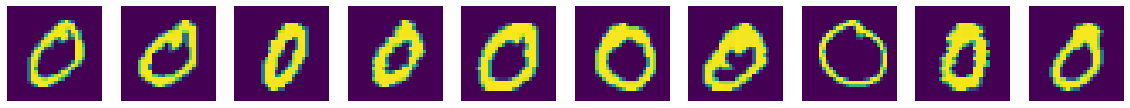

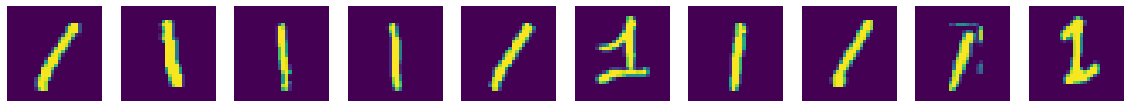

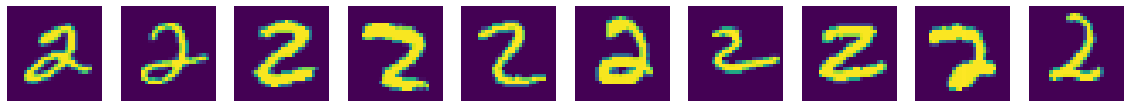

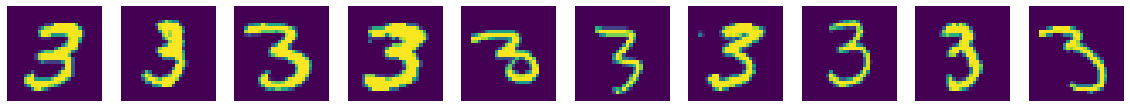

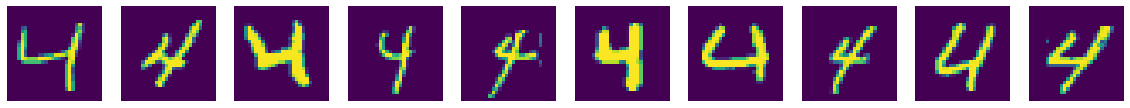

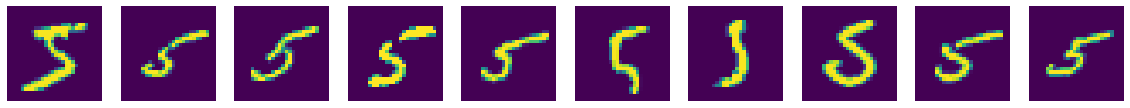

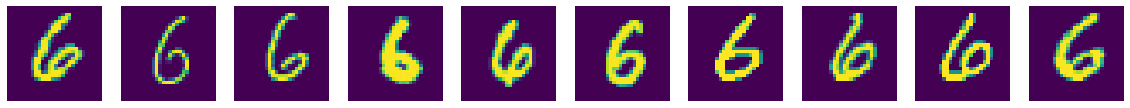

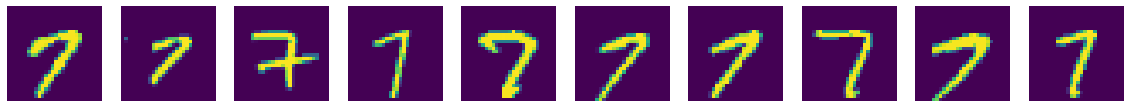

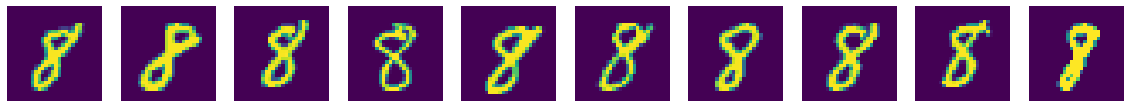

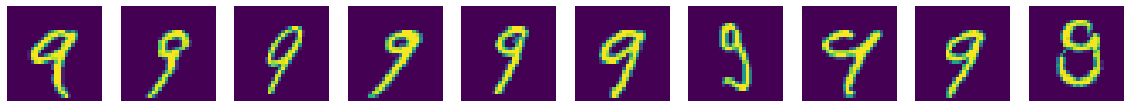

In [3]:
byLab = lambda imglab : imglab[1]
byImg = lambda imglab : imglab[0]

# number of train and test images
print(f"number of train images: {len( trainD )}")
print(f"number of train images: {len( testD )}")
print("\n")

# number of training and test images for each class
print("train:")
print([ f"label_{k}:{len(list(v))}" 
       for k,v 
       in groupby(sorted(trainD, key = byLab), key = byLab )])

print("test:")
print([ f"label_{k}:{len(list(v))}" 
       for k,v 
       in groupby(sorted(testD, key = byLab), key = byLab )])

print("\n")

# example images:
imgsPerlabs = [(lab,list(map(byImg,imgs))) 
               for lab,imgs 
               in groupby(sorted(trainD, key = byLab), key = byLab)]

for lab,imgs in imgsPerlabs:

    imgs = imgs[:10]
    imgN = len(imgs)
    fig, axes = plt.subplots(1,imgN, figsize = (imgN * 2, 1 * 3))

    for ax,img in zip(axes,imgs): 

        ax.imshow(img)
        ax.axis('off')

    plt.show()    

### 2.preprocess

we have four preprocessing steps to be done on the dataset: 0) to tensor; 1) only subsetting 0 and 1.; 2) normalization; 3) flattening.

0. To tensor.tensor
    To use Pytorch APIs, we need our data to be in torch.tesor type

1. Only subset 0 and 1
   Since we only allowed 2 outcomes (0 and 1) we will take only 2 classes from the dataset.  I will choose 0 and 1 only.
    
2. nomalization
    Same as Linear Regression, for numerical stability
    
3. flattening
    Logistic regression model only allows the data to be in a colum vector, so we flatten image (i.e $\mathbb{R}^{HxW} \rightarrow \mathbb{R}^{HW} $)

In [4]:
# to tensor
toTensor = lambda pair: (transforms.ToTensor()(pair[0]), pair[1])
trainD = map(toTensor, trainD)
testD  = map(toTensor, testD)

# subsetting 0 and 1
only01 = lambda pair : pair[1] in [0,1]
trainD = filter(only01, trainD)
testD  = filter(only01, testD)

# normalisation
normalize = lambda pair: (transforms.Normalize(mean=[0], std=[1])(pair[0]), pair[1] )
trainD = map(normalize, trainD)
testD  = map(normalize, testD)

# flatten
flatten = lambda pair: ( torch.flatten(pair[0]), pair[1] )
trainD = map(flatten, trainD)
testD  = map(flatten, testD)

processedTrainD = list(trainD)
processedTestD  = list(testD)

### Load as Batch
As mentioned from previous lecture, batch training is one of tricks we use to solve memory issue. Let's trasform the processed data to a batchLoader

In [5]:
trainX = torch.stack(list(map(lambda pair : pair[0], processedTrainD)))
trainY = torch.tensor(list(map(lambda pair : pair[1], processedTrainD)))

trainLoader = DataLoader( TensorDataset(trainX, trainY), batch_size = 100)

testX = torch.stack(list(map(lambda pair : pair[0], processedTestD)))
testY = torch.tensor(list(map(lambda pair : pair[1], processedTestD)))

testLoader = DataLoader( TensorDataset(testX, testY), batch_size = 100)

### Defining Logistic regresison

Now lets define the 1) model 2) loss function and 3) optimizer. This time round, we will not hard code everything like before. But fully utilize Pytorch API

#### Model

\begin{equation}    
f_{\theta} = \sigma(\theta^{T}x)
\end{equation}

You see that the inference function $f_{\theta}$ is simply is a composition of an inner product and a non-linear operation $\sigma$. We dont need to hard code these, Pytorch handles for us

In [6]:
model = nn.Sequential(nn.Linear(28*28, 1), # innner product
                      nn.Sigmoid())        # sigma


def inferenceStep(X):
    yHat = f(X)
    return yHat

#### Loss

\begin{align}
J(\theta) &= -\text{log}\sum_{i=1}^{i=N} p( y_i| x_i ; \theta )
\end{align}

Loss fuction is also avaible! lets just call them. 

In [7]:
J = torch.nn.BCELoss() # binary cross entrophy loss

### Optimizer

We will use SGD with momentum

In [8]:
print("configuring optimizer")
optimizer = SGD(model.parameters(),
                lr = 0.01,
                momentum = 0.5)


configuring optimizer


#### Training framework

We now have all the key components of our model. lets build a training framework!

In [49]:
# initialize model
                
# train
for e in range(20):
    losses = []
    for X,y in trainLoader:
        
        X = X.type(torch.float32)
        y = y.type(torch.float32)
        
        model.train()
        optimizer.zero_grad()
        
        yHat = model(X)

        loss = J(yHat.squeeze(),y.squeeze())        
        losses.append(loss.item())
        loss.backward()                        
        optimizer.step()        
    print(f"Loss at epoch:{e} = {np.mean(losses)}")

Loss at epoch:0 = 0.03581995277218227
Loss at epoch:1 = 0.025640211068093777
Loss at epoch:2 = 0.02103824098044493
Loss at epoch:3 = 0.018264025966746835
Loss at epoch:4 = 0.016376949447082487
Loss at epoch:5 = 0.014994478762501807
Loss at epoch:6 = 0.013929204421308567
Loss at epoch:7 = 0.013077705119567828
Loss at epoch:8 = 0.01237788646093269
Loss at epoch:9 = 0.01179004871968444
Loss at epoch:10 = 0.011287533720280594
Loss at epoch:11 = 0.010851717515533247
Loss at epoch:12 = 0.010469162954002853
Loss at epoch:13 = 0.010129909988082065
Loss at epoch:14 = 0.00982640741216972
Loss at epoch:15 = 0.009552813506333201
Loss at epoch:16 = 0.009304530720600463
Loss at epoch:17 = 0.009077891593754996
Loss at epoch:18 = 0.008869922577814148
Loss at epoch:19 = 0.008678191313043412


#### Evaluation 
Looking at the decrease in loss, it looks promising! Lets now see how it performs on a test set.

In [46]:
# test
yHats = []
ys    = []
for X,y in testLoader:

    X = X.type(torch.float32)
    y = y.type(torch.float32)
    
    model.eval()
    yHat = model(X)
    
    ys.append(y.detach().numpy())
    yHats.append(yHat.detach().numpy())
    
yHats = np.concatenate(yHats)
ys    = np.concatenate(ys)

acc = sum(np.round(yHats).squeeze() == ys) / len(ys) * 100 

print(f"test acc : {str(acc)[:4]} %" )

test acc : 99.9 %


#### Regularization (additional)

One common problem of many AI models is that they might perform well on a train set but poorly on a test set. This is also known as the problem of "Bias vs Variance" trade off. One common way to solve the problem in Logistic Regression is to add a regularizer that limits the flexibility of the parameter $\theta$. Broadly there two types of regularizers: L1 norm and L2 norm regularizer. To introduce the regularizers during a training, we simple add eiter L1 or L2 norm of the weights $\theta$ to the Loss function as a contraint. For example, for L1 regularizer :

\begin{equation}
J(\theta)  = - \sum_{i=1}^{N}[ y_i\text{log}( \sigma(\theta^{T}x_i) ) * (1-y_i)\text{log} (1 - \sigma(\theta^{T}x_i)) ]  + \lambda ||\theta||_1
\end{equation}

where $\lambda$ is a hyperparamter.

In [54]:
model = nn.Sequential(nn.Linear(28*28, 1), # innner product
                      nn.Sigmoid())        # sigma

def inferenceStep(X):
    yHat = f(X)
    return yHat

J = torch.nn.BCELoss() # binary cross entrophy loss

print("configuring optimizer")
optimizer = SGD(model.parameters(),
                lr = 0.01,
                momentum = 0.5)

                
# train
for e in range(20):
    losses = []
    for X,y in trainLoader:
        
        X = X.type(torch.float32)
        y = y.type(torch.float32)
        
        model.train()
        optimizer.zero_grad()

        yHat = model(X)
        
        ###########################
        l1_lambda = 0.001
        l1_reg = torch.tensor(0.)        
        loss = J(yHat.squeeze(),y.squeeze())        
        
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)
        loss += l1_lambda * l1_reg
        ####################################
        
        losses.append(loss.item())
        loss.backward()                        
        optimizer.step()        
    print(f"Loss at epoch:{e} = {np.mean(losses)}")

configuring optimizer
Loss at epoch:0 = 0.17613390929938302
Loss at epoch:1 = 0.06850898482902783
Loss at epoch:2 = 0.05561520264843318
Loss at epoch:3 = 0.04965333558443025
Loss at epoch:4 = 0.045969641760108974
Loss at epoch:5 = 0.04337455742941128
Loss at epoch:6 = 0.04143422001635465
Loss at epoch:7 = 0.03991844106142915
Loss at epoch:8 = 0.038707809156085564
Loss at epoch:9 = 0.037724099026655585
Loss at epoch:10 = 0.03690306403798851
Loss at epoch:11 = 0.03623436656817207
Loss at epoch:12 = 0.03571315134662812
Loss at epoch:13 = 0.03530686573074089
Loss at epoch:14 = 0.03499698363185868
Loss at epoch:15 = 0.034737694788518854
Loss at epoch:16 = 0.03450818691314675
Loss at epoch:17 = 0.034301444917447924
Loss at epoch:18 = 0.034115556128851074
Loss at epoch:19 = 0.03394872073348113


In [56]:
# test
yHats = []
ys    = []
for X,y in testLoader:

    X = X.type(torch.float32)
    y = y.type(torch.float32)
    
    model.eval()
    yHat = model(X)
    
    ys.append(y.detach().numpy())
    yHats.append(yHat.detach().numpy())
    
yHats = np.concatenate(yHats)
ys    = np.concatenate(ys)

acc = sum(np.round(yHats).squeeze() == ys) / len(ys) * 100 

print(f"test acc : {str(acc)[:4]} %" )

test acc : 99.8 %
